In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/Shareddrives/Data 245 Project/Project Code

/content/drive/Shareddrives/Data 245 Project/Project Code


In [3]:
!ls

 245v2+EDA.ipynb	    glove.6B.300d.txt
 fake_job_postings.csv	    Project_245_fakejob_raw.ipynb
 fake_job_postings.gsheet   randomForest.pkl
 glove.6B.200d.rar	   'Results of Models.gsheet'
 glove.6B.200d.txt	    v2.Project_245_fakejob_raw.ipynb
 glove.6B.300d.rar	    v3.Project_245_fakejob.ipynb


# Import Libraries

In [4]:
!pip install scikit-plot

In [5]:
import pandas as pd
import numpy as np
from math import sqrt
import pickle
import time

import nltk
import re
import string
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize

import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

import sklearn.metrics as metrics
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier


In [6]:
data = pd.read_csv('fake_job_postings.csv')

In [7]:
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [9]:
data.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [10]:
data.fillna("missing", inplace = True) #filling missing values with text 'missing'

In [11]:
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,missing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,missing,0,1,0,Other,Internship,missing,missing,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,missing,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,missing,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",missing,missing,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,missing,0,1,0,missing,missing,missing,missing,missing,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,missing,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",missing,missing,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


#### Separating country and city from location

In [12]:
data['country'] = data['location'].str.split(',').apply(lambda x: x[0])
data['city'] = data['location'].str.split(',').apply(lambda x: x[-1])

In [13]:
data.head(1)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,city
0,1,Marketing Intern,"US, NY, New York",Marketing,missing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,missing,0,1,0,Other,Internship,missing,missing,Marketing,0,US,New York


#### Separating min and max salary range

In [14]:
data['min_salary'] = data['salary_range'].str.split('-').apply(lambda x: x[0])
data['max_salary'] = data['salary_range'].str.split('-').apply(lambda x: x[-1])

In [15]:
data.head(1)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,employment_type,required_experience,required_education,industry,function,fraudulent,country,city,min_salary,max_salary
0,1,Marketing Intern,"US, NY, New York",Marketing,missing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,missing,0,...,Other,Internship,missing,missing,Marketing,0,US,New York,missing,missing


#### Using Natural Language Toolkit for text processing

import nltk
nltk.download()

In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
#data['tokenized_description'] = data['description'].apply(word_tokenize)

In [18]:
#data.head(1)

In [19]:
#from nltk.probability import FreqDist
#frequency = data['tokenized_description'].apply(FreqDist)

In [20]:
#frequency

In [21]:
text_data = data[["title", "company_profile", "description", "requirements", "benefits"]]
text_data = text_data.fillna(' ')

text_data.head()

,title,company_profile,description,requirements,benefits
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,missing
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,missing
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered


In [22]:
cat_data = data[["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education", "industry", "function",]]

cat_data.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function
0,0,1,0,Other,Internship,missing,missing,Marketing
1,0,1,0,Full-time,Not Applicable,missing,Marketing and Advertising,Customer Service
2,0,1,0,missing,missing,missing,missing,missing
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider


In [23]:
label_columns = ['telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function']
lb_make = LabelEncoder()
for i in label_columns:
    cat_data[i] = lb_make.fit_transform(cat_data[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [24]:
cat_data

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function
0,0,1,0,2,4,13,131,22
1,0,1,0,1,6,13,75,7
2,0,1,0,5,7,13,131,37
3,0,1,0,1,5,1,22,31
4,0,1,1,1,5,1,51,16
...,...,...,...,...,...,...,...,...
17875,0,1,1,1,5,13,22,31
17876,0,1,1,1,5,1,61,0
17877,0,0,0,1,7,13,131,37
17878,0,0,1,0,6,6,48,9


# Text Data Processing

## Look at text columns

In [25]:
text = text_data[text_data.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = data['fraudulent']

print(len(text))
print(len(target))
print(text)

17880
17880
0        Marketing Intern,We're Food52, and we've creat...
1        Customer Service - Cloud Video Production,90 S...
2        Commissioning Machinery Assistant (CMA),Valor ...
3        Account Executive - Washington DC,Our passion ...
4        Bill Review Manager,SpotSource Solutions LLC i...
                               ...                        
17875    Account Director - Distribution ,Vend is looki...
17876    Payroll Accountant,WebLinc is the e-commerce p...
17877    Project Cost Control Staff Engineer - Cost Con...
17878    Graphic Designer,missing,Nemsia Studios is loo...
17879    Web Application Developers,Vend is looking for...
Length: 17880, dtype: object


## Function for cleaning up the text data

In [26]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation and remove words containing numbers.'''
    text = text.lower() # Lower case
    text = re.sub('\[.*?\]', '', text) # No text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) # Remove HTML links
    text = re.sub('<.*?>+', '', text) # Remove punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuations
    text = re.sub('\n', '', text) # Remove new lines
    text = re.sub('\w*\d\w*', '', text) # Remove words with numbers
    return text


# Applying the cleaning function to both test and training datasets
text = text.apply(lambda x: clean_text(x))
text.head(10)


0    marketing internwere  and weve created a groun...
1    customer service  cloud video  seconds the wor...
2    commissioning machinery assistant cmavalor ser...
3    account executive  washington dcour passion fo...
4    bill review managerspotsource solutions llc is...
5    accounting clerkmissingjob overviewapex is an ...
6    head of content mffounded in  the fonpit ag ro...
7    lead guest service specialist   airenvy’s miss...
8    hp bsm  is a womanowned small business whose f...
9    customer service associate  part time novitex ...
dtype: object

## Tokenizer

In [27]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# appling tokenizer5
text = text.apply(lambda x: tokenizer.tokenize(x))
text.head(3)

0    [marketing, internwere, and, weve, created, a,...
1    [customer, service, cloud, video, seconds, the...
2    [commissioning, machinery, assistant, cmavalor...
dtype: object

## Removing stopwords in English

In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [30]:
stop_words = stopwords.words('english')
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [w for w in text if w not in stop_words]
    return words


text = text.apply(lambda x : remove_stopwords(x))

In [31]:
text

0        [marketing, internwere, weve, created, groundb...
1        [customer, service, cloud, video, seconds, wor...
2        [commissioning, machinery, assistant, cmavalor...
3        [account, executive, washington, dcour, passio...
4        [bill, review, managerspotsource, solutions, l...
                               ...                        
17875    [account, director, distribution, vend, lookin...
17876    [payroll, accountantweblinc, ecommerce, platfo...
17877    [project, cost, control, staff, engineer, cost...
17878    [graphic, designermissingnemsia, studios, look...
17879    [web, application, developersvend, looking, aw...
Length: 17880, dtype: object

In [32]:
text.apply(lambda x: [item for item in x if item not in stop])

0        [marketing, internwere, weve, created, groundb...
1        [customer, service, cloud, video, seconds, wor...
2        [commissioning, machinery, assistant, cmavalor...
3        [account, executive, washington, dcour, passio...
4        [bill, review, managerspotsource, solutions, l...
                               ...                        
17875    [account, director, distribution, vend, lookin...
17876    [payroll, accountantweblinc, ecommerce, platfo...
17877    [project, cost, control, staff, engineer, cost...
17878    [graphic, designermissingnemsia, studios, look...
17879    [web, application, developersvend, looking, aw...
Length: 17880, dtype: object

## Lemmatization

In [33]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [34]:
new_text = pd.DataFrame(text, columns = ['texts'])

In [35]:
new_text

,texts
0,"[marketing, internwere, weve, created, groundb..."
1,"[customer, service, cloud, video, seconds, wor..."
2,"[commissioning, machinery, assistant, cmavalor..."
3,"[account, executive, washington, dcour, passio..."
4,"[bill, review, managerspotsource, solutions, l..."
...,...
17875,"[account, director, distribution, vend, lookin..."
17876,"[payroll, accountantweblinc, ecommerce, platfo..."
17877,"[project, cost, control, staff, engineer, cost..."
17878,"[graphic, designermissingnemsia, studios, look..."


In [36]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatization(text):
    return [lemmatizer.lemmatize(x) for x in text]

new_text['text_lemmatized'] = new_text.texts.apply(lemmatization)

In [37]:
new_text

,texts,text_lemmatized
0,"[marketing, internwere, weve, created, groundb...","[marketing, internwere, weve, created, groundb..."
1,"[customer, service, cloud, video, seconds, wor...","[customer, service, cloud, video, second, worl..."
2,"[commissioning, machinery, assistant, cmavalor...","[commissioning, machinery, assistant, cmavalor..."
3,"[account, executive, washington, dcour, passio...","[account, executive, washington, dcour, passio..."
4,"[bill, review, managerspotsource, solutions, l...","[bill, review, managerspotsource, solution, ll..."
...,...,...
17875,"[account, director, distribution, vend, lookin...","[account, director, distribution, vend, lookin..."
17876,"[payroll, accountantweblinc, ecommerce, platfo...","[payroll, accountantweblinc, ecommerce, platfo..."
17877,"[project, cost, control, staff, engineer, cost...","[project, cost, control, staff, engineer, cost..."
17878,"[graphic, designermissingnemsia, studios, look...","[graphic, designermissingnemsia, studio, looki..."


## Combine Text

In [38]:
new_text['lemmatize'] = new_text['text_lemmatized'].apply(lambda x: ' '.join(word for word in x))

In [39]:
new_text

,texts,text_lemmatized,lemmatize
0,"[marketing, internwere, weve, created, groundb...","[marketing, internwere, weve, created, groundb...",marketing internwere weve created groundbreaki...
1,"[customer, service, cloud, video, seconds, wor...","[customer, service, cloud, video, second, worl...",customer service cloud video second world clou...
2,"[commissioning, machinery, assistant, cmavalor...","[commissioning, machinery, assistant, cmavalor...",commissioning machinery assistant cmavalor ser...
3,"[account, executive, washington, dcour, passio...","[account, executive, washington, dcour, passio...",account executive washington dcour passion imp...
4,"[bill, review, managerspotsource, solutions, l...","[bill, review, managerspotsource, solution, ll...",bill review managerspotsource solution llc glo...
...,...,...,...
17875,"[account, director, distribution, vend, lookin...","[account, director, distribution, vend, lookin...",account director distribution vend looking awe...
17876,"[payroll, accountantweblinc, ecommerce, platfo...","[payroll, accountantweblinc, ecommerce, platfo...",payroll accountantweblinc ecommerce platform s...
17877,"[project, cost, control, staff, engineer, cost...","[project, cost, control, staff, engineer, cost...",project cost control staff engineer cost contr...
17878,"[graphic, designermissingnemsia, studios, look...","[graphic, designermissingnemsia, studio, looki...",graphic designermissingnemsia studio looking e...


## Combine Data

In [40]:
new_data = pd.merge(cat_data, new_text[['lemmatize']], left_index=True, right_index=True)

In [41]:
new_data = pd.merge(new_data, data[['fraudulent']], left_index=True, right_index=True)

In [42]:
new_data

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,lemmatize,fraudulent
0,0,1,0,2,4,13,131,22,marketing internwere weve created groundbreaki...,0
1,0,1,0,1,6,13,75,7,customer service cloud video second world clou...,0
2,0,1,0,5,7,13,131,37,commissioning machinery assistant cmavalor ser...,0
3,0,1,0,1,5,1,22,31,account executive washington dcour passion imp...,0
4,0,1,1,1,5,1,51,16,bill review managerspotsource solution llc glo...,0
...,...,...,...,...,...,...,...,...,...,...
17875,0,1,1,1,5,13,22,31,account director distribution vend looking awe...,0
17876,0,1,1,1,5,1,61,0,payroll accountantweblinc ecommerce platform s...,0
17877,0,0,0,1,7,13,131,37,project cost control staff engineer cost contr...,0
17878,0,0,1,0,6,6,48,9,graphic designermissingnemsia studio looking e...,0


In [43]:
save_data = new_data

## Train Test

In [44]:
X = new_data.iloc[:, :-1]
y = new_data.iloc[:, -1]

In [45]:
X

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,lemmatize
0,0,1,0,2,4,13,131,22,marketing internwere weve created groundbreaki...
1,0,1,0,1,6,13,75,7,customer service cloud video second world clou...
2,0,1,0,5,7,13,131,37,commissioning machinery assistant cmavalor ser...
3,0,1,0,1,5,1,22,31,account executive washington dcour passion imp...
4,0,1,1,1,5,1,51,16,bill review managerspotsource solution llc glo...
...,...,...,...,...,...,...,...,...,...
17875,0,1,1,1,5,13,22,31,account director distribution vend looking awe...
17876,0,1,1,1,5,1,61,0,payroll accountantweblinc ecommerce platform s...
17877,0,0,0,1,7,13,131,37,project cost control staff engineer cost contr...
17878,0,0,1,0,6,6,48,9,graphic designermissingnemsia studio looking e...


In [46]:
#z_train

## Unrar

In [47]:
#!unrar x "glove.6B.300d.rar" "/content/drive/Shareddrives/Data 245 Project/Project Code/"

In [48]:
embeddings_index = {}
f = open('glove.6B.200d.txt', encoding="utf8")
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vectors representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

In [49]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [50]:
glove_words =  set(embeddings_index.keys())

def convert_sen_to_vec(sentence):
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sentence.split():
        if word in glove_words:
            vector += embeddings_index[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    return vector

In [51]:
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(200)
    return v / np.sqrt((v ** 2).sum())

In [52]:
converted_data = []

for i in range(0, new_data.shape[0]):
    converted_data.append(sent2vec(new_data['lemmatize'][i]))

In [53]:
_1 = pd.DataFrame(converted_data)

In [54]:
new_data = new_data.drop(columns=['lemmatize'])

In [55]:
new_data

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,2,4,13,131,22,0
1,0,1,0,1,6,13,75,7,0
2,0,1,0,5,7,13,131,37,0
3,0,1,0,1,5,1,22,31,0
4,0,1,1,1,5,1,51,16,0
...,...,...,...,...,...,...,...,...,...
17875,0,1,1,1,5,13,22,31,0
17876,0,1,1,1,5,1,61,0,0
17877,0,0,0,1,7,13,131,37,0
17878,0,0,1,0,6,6,48,9,0


In [56]:
main_data = pd.concat([_1,new_data], axis=1)

In [57]:
main_data

,0,1,2,3,4,5,6,7,8,9,...,199,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,-0.002061,0.066000,-0.017966,-0.061503,0.030577,-0.019662,-0.085162,0.000982,-0.030580,0.030815,...,0.015658,0,1,0,2,4,13,131,22,0
1,0.028571,0.063619,-0.053331,-0.056595,0.022424,0.000128,-0.069555,0.009650,0.013362,0.031480,...,0.016425,0,1,0,1,6,13,75,7,0
2,0.031692,0.078740,0.024006,-0.062013,0.007968,-0.018392,-0.071365,0.035503,0.021990,0.008586,...,-0.001151,0,1,0,5,7,13,131,37,0
3,0.040483,0.059467,0.008781,-0.013202,0.032882,-0.009149,-0.084195,0.038128,0.002978,0.056617,...,0.017022,0,1,0,1,5,1,22,31,0
4,0.036627,0.049534,0.018203,-0.034942,0.029900,-0.005607,-0.078676,0.016035,0.003705,0.035780,...,0.006174,0,1,1,1,5,1,51,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0.052695,0.037381,-0.032322,-0.042386,0.017173,-0.008292,-0.074659,0.007101,-0.000324,0.047896,...,0.026960,0,1,1,1,5,13,22,31,0
17876,0.051455,0.064098,-0.015834,-0.028895,0.040883,-0.026099,-0.067135,0.025180,-0.007879,0.052108,...,0.021530,0,1,1,1,5,1,61,0,0
17877,0.036313,0.027983,0.022579,-0.028348,0.046630,-0.006606,-0.085808,0.003379,0.005933,0.043600,...,-0.001572,0,0,0,1,7,13,131,37,0
17878,0.023673,0.069232,-0.036682,-0.078467,0.079021,-0.016263,-0.117926,0.013720,0.048151,0.027105,...,-0.005863,0,0,1,0,6,6,48,9,0


In [58]:
main_data.columns = main_data.columns.astype(str)

In [59]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   telecommuting        17880 non-null  int64
 1   has_company_logo     17880 non-null  int64
 2   has_questions        17880 non-null  int64
 3   employment_type      17880 non-null  int64
 4   required_experience  17880 non-null  int64
 5   required_education   17880 non-null  int64
 6   industry             17880 non-null  int64
 7   function             17880 non-null  int64
 8   fraudulent           17880 non-null  int64
dtypes: int64(9)
memory usage: 1.2 MB


In [60]:
scaler = StandardScaler()

main_data[['required_education', 'required_experience', 'employment_type','industry','function']] = StandardScaler().fit_transform(main_data[['required_education', 'required_experience', 'employment_type','industry','function']])

In [61]:
main_data

,0,1,2,3,4,5,6,7,8,9,...,199,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,-0.002061,0.066000,-0.017966,-0.061503,0.030577,-0.019662,-0.085162,0.000982,-0.030580,0.030815,...,0.015658,0,1,0,0.099313,-0.248399,1.005226,1.308985,-0.145416,0
1,0.028571,0.063619,-0.053331,-0.056595,0.022424,0.000128,-0.069555,0.009650,0.013362,0.031480,...,0.016425,0,1,0,-0.497368,0.537615,1.005226,0.011506,-1.352449,0
2,0.031692,0.078740,0.024006,-0.062013,0.007968,-0.018392,-0.071365,0.035503,0.021990,0.008586,...,-0.001151,0,1,0,1.889358,0.930622,1.005226,1.308985,1.061618,0
3,0.040483,0.059467,0.008781,-0.013202,0.032882,-0.009149,-0.084195,0.038128,0.002978,0.056617,...,0.017022,0,1,0,-0.497368,0.144608,-1.229790,-1.216466,0.578804,0
4,0.036627,0.049534,0.018203,-0.034942,0.029900,-0.005607,-0.078676,0.016035,0.003705,0.035780,...,0.006174,0,1,1,-0.497368,0.144608,-1.229790,-0.544557,-0.628229,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0.052695,0.037381,-0.032322,-0.042386,0.017173,-0.008292,-0.074659,0.007101,-0.000324,0.047896,...,0.026960,0,1,1,-0.497368,0.144608,1.005226,-1.216466,0.578804,0
17876,0.051455,0.064098,-0.015834,-0.028895,0.040883,-0.026099,-0.067135,0.025180,-0.007879,0.052108,...,0.021530,0,1,1,-0.497368,0.144608,-1.229790,-0.312864,-1.915731,0
17877,0.036313,0.027983,0.022579,-0.028348,0.046630,-0.006606,-0.085808,0.003379,0.005933,0.043600,...,-0.001572,0,0,0,-0.497368,0.930622,1.005226,1.308985,1.061618,0
17878,0.023673,0.069232,-0.036682,-0.078467,0.079021,-0.016263,-0.117926,0.013720,0.048151,0.027105,...,-0.005863,0,0,1,-1.094049,0.537615,-0.298533,-0.614065,-1.191511,0


## Apply SMOTE

In [62]:
#!pip install -U imbalanced-learn

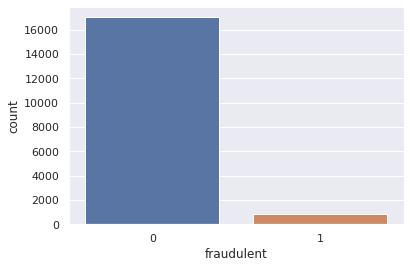

In [63]:
sns.set(style="darkgrid")
sns.countplot(x = "fraudulent" , data = new_data)

In [64]:
X = main_data.iloc[:, :-1]
y = main_data.iloc[:, -1]

In [65]:
print(len(X))
print(len(y))

17880
17880


In [66]:
oversample = SMOTE()
new_X, new_y = oversample.fit_resample(X, y)

In [67]:
print(len(new_X))
print(len(new_y))

34028
34028


In [68]:
new_y.value_counts()

0    17014
1    17014
Name: fraudulent, dtype: int64

#DF for Multinomial Naive Bayes

In [69]:
test_data = save_data

In [70]:
save_data

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,lemmatize,fraudulent
0,0,1,0,2,4,13,131,22,marketing internwere weve created groundbreaki...,0
1,0,1,0,1,6,13,75,7,customer service cloud video second world clou...,0
2,0,1,0,5,7,13,131,37,commissioning machinery assistant cmavalor ser...,0
3,0,1,0,1,5,1,22,31,account executive washington dcour passion imp...,0
4,0,1,1,1,5,1,51,16,bill review managerspotsource solution llc glo...,0
...,...,...,...,...,...,...,...,...,...,...
17875,0,1,1,1,5,13,22,31,account director distribution vend looking awe...,0
17876,0,1,1,1,5,1,61,0,payroll accountantweblinc ecommerce platform s...,0
17877,0,0,0,1,7,13,131,37,project cost control staff engineer cost contr...,0
17878,0,0,1,0,6,6,48,9,graphic designermissingnemsia studio looking e...,0


In [71]:
test_data.drop(test_data.iloc[:, 0:8], inplace = True, axis = 1)

In [72]:
test_data

,lemmatize,fraudulent
0,marketing internwere weve created groundbreaki...,0
1,customer service cloud video second world clou...,0
2,commissioning machinery assistant cmavalor ser...,0
3,account executive washington dcour passion imp...,0
4,bill review managerspotsource solution llc glo...,0
...,...,...
17875,account director distribution vend looking awe...,0
17876,payroll accountantweblinc ecommerce platform s...,0
17877,project cost control staff engineer cost contr...,0
17878,graphic designermissingnemsia studio looking e...,0


In [73]:
Xx = test_data.iloc[:, :-1]
Yy = test_data.iloc[:, -1]

In [74]:
test_data.lemmatize

0        marketing internwere weve created groundbreaki...
1        customer service cloud video second world clou...
2        commissioning machinery assistant cmavalor ser...
3        account executive washington dcour passion imp...
4        bill review managerspotsource solution llc glo...
                               ...                        
17875    account director distribution vend looking awe...
17876    payroll accountantweblinc ecommerce platform s...
17877    project cost control staff engineer cost contr...
17878    graphic designermissingnemsia studio looking e...
17879    web application developersvend looking awesome...
Name: lemmatize, Length: 17880, dtype: object

In [75]:
X_tr, X_te, y_tr, y_te = train_test_split(test_data.lemmatize, test_data.fraudulent, test_size=0.2, random_state=10)

In [76]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(X_tr)
#transformed test reviews
tv_test_reviews=tv.transform(X_te)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (14304, 1630498)
Tfidf_test: (3576, 1630498)


In [77]:
oversample = SMOTE()
the_X, the_y = oversample.fit_resample(tv_train_reviews, y_tr)

#End Testing Zone

# Correlation Graphs

In [78]:
main_data_corr = main_data.copy()

In [79]:
main_data_corr.drop(main_data_corr.iloc[:, 0:200], inplace = True, axis = 1)

In [80]:
main_data_corr

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,0.099313,-0.248399,1.005226,1.308985,-0.145416,0
1,0,1,0,-0.497368,0.537615,1.005226,0.011506,-1.352449,0
2,0,1,0,1.889358,0.930622,1.005226,1.308985,1.061618,0
3,0,1,0,-0.497368,0.144608,-1.229790,-1.216466,0.578804,0
4,0,1,1,-0.497368,0.144608,-1.229790,-0.544557,-0.628229,0
...,...,...,...,...,...,...,...,...,...
17875,0,1,1,-0.497368,0.144608,1.005226,-1.216466,0.578804,0
17876,0,1,1,-0.497368,0.144608,-1.229790,-0.312864,-1.915731,0
17877,0,0,0,-0.497368,0.930622,1.005226,1.308985,1.061618,0
17878,0,0,1,-1.094049,0.537615,-0.298533,-0.614065,-1.191511,0


In [81]:
corr = main_data_corr.corr()

corr.style.background_gradient(cmap='coolwarm')

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
telecommuting,1.000000,-0.019836,0.020345,-0.015372,-0.034689,-0.001100,-0.012522,-0.037338,0.034523
has_company_logo,-0.019836,1.000000,0.233932,-0.057829,-0.158293,-0.176888,-0.120947,-0.142539,-0.261971
has_questions,0.020345,0.233932,1.000000,-0.020335,-0.059089,-0.121461,-0.040103,-0.053456,-0.091627
employment_type,-0.015372,-0.057829,-0.020335,1.000000,0.362176,0.439478,0.558086,0.362255,0.057070
required_experience,-0.034689,-0.158293,-0.059089,0.362176,1.000000,0.427080,0.378939,0.418974,0.041328
required_education,-0.001100,-0.176888,-0.121461,0.439478,0.427080,1.000000,0.421885,0.404328,0.048955
industry,-0.012522,-0.120947,-0.040103,0.558086,0.378939,0.421885,1.000000,0.373065,0.037297
function,-0.037338,-0.142539,-0.053456,0.362255,0.418974,0.404328,0.373065,1.000000,-0.047461
fraudulent,0.034523,-0.261971,-0.091627,0.057070,0.041328,0.048955,0.037297,-0.047461,1.000000


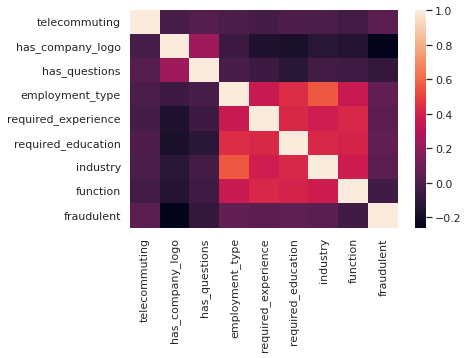

In [82]:
sns.heatmap(main_data_corr.corr())

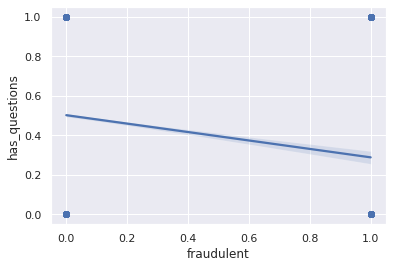

In [83]:
sns.regplot(x=main_data_corr["fraudulent"], y=main_data_corr["has_questions"])

# Model Dev

## Split Training and Testing and Apply SMOTE

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

oversample = SMOTE()
X_train_bal, y_train_bal = oversample.fit_resample(X_train, y_train)

In [85]:
print(len(X_train))
print(len(y_train))
print(len(X_train_bal))
print(len(y_train_bal))

14304
14304
27196
27196


## Random Forest

### Search for Optimal RF Parameters

In [100]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 20, num = 5)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 4,scoring = 'f1')
rf_random.fit(X_train_bal, y_train_bal)

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, None],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [5, 8, 12, 16, 20]},
                   scoring='f1')

In [101]:
print("Average of the best f1-score in various folds during cross validation = ",rf_random.best_score_)
print("The best parameters found during k-fold cross validation is = ",rf_random.best_params_)

Average of the best f1-score in various folds during cross validation =  0.9864778579150387
The best parameters found during k-fold cross validation is =  {'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}


### Train

In [102]:
rfc = RandomForestClassifier(n_estimators=20, min_samples_split = 2, min_samples_leaf = 2, max_depth= 40)

In [103]:
start = time.time()

rfc.fit(X_train_bal, y_train_bal)
rf_pred = rfc.predict(X_test)

end = time.time()
print('Random Forest took: ', end - start, "seconds")

Random Forest took:  8.800160646438599 seconds


### Pickle Model

In [104]:
#pickle.dump(rfc, open('randomForest.pkl', 'wb'))

### Load Pickled Model

In [105]:
#pickled_model = pickle.load(open('randomForest.pkl', 'rb'))
#what = pickled_model.predict(X_test)

In [106]:
#print ("AUC score :", np.round(roc_auc_score(y_test, what),2))
#print("Accuracy:",round(metrics.accuracy_score(y_test, what),2))

In [107]:
rf_recall  = metrics.recall_score(y_test, rf_pred)
rf_f1_score = metrics.f1_score(y_test,rf_pred) 


print ("Recall :%.2f "% rf_recall)
print("F1_Score: %.2f "% rf_f1_score)
print ("AUC score :", np.round(roc_auc_score(y_test, rf_pred),2))
print("Accuracy:",round(metrics.accuracy_score(y_test, rf_pred),2))

Recall :0.64 
F1_Score: 0.71 
AUC score : 0.82
Accuracy: 0.98


### Confusion Matrix

In [108]:
#Generate the confusion matrix
rf_cf_matrix = confusion_matrix(y_test, rf_pred)

print(rf_cf_matrix)

[[3388   28]
 [  57  103]]


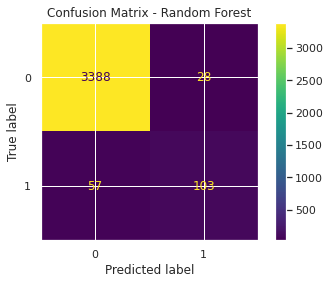

In [109]:
ConfusionMatrixDisplay.from_predictions(y_test, rf_pred)
plt.title("Confusion Matrix - Random Forest")
plt.show()

### ROC Using Probability

In [110]:
rf_proba = rfc.predict_proba(X_test)

Text(0.5, 1.0, 'ROC Curves - Random Forest')

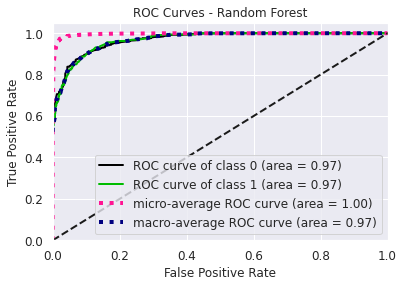

In [111]:
plot = skplt.metrics.plot_roc(y_test, rf_proba)
plt.title("ROC Curves - Random Forest")

In [112]:
rf_proba = rf_proba[:, 1]

In [113]:
rf_auc = roc_auc_score(y_test, rf_proba)

In [114]:
print('Logistic: ROC AUC=%.2f' % (rf_auc))

Logistic: ROC AUC=0.97


In [115]:
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba)

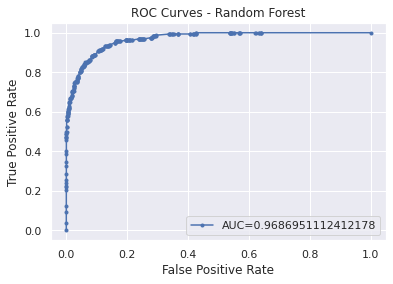

In [116]:
plt.plot(rf_fpr, rf_tpr, marker='.', label="AUC="+str(rf_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curves - Random Forest")
plt.legend()
plt.show()


#Multinomial Naive Bayes

In [117]:
#training the model
mnb=MultinomialNB(alpha = 1)

In [118]:
start = time.time()

mnb.fit(the_X,the_y)
mnb_tfidf_predict=mnb.predict(tv_test_reviews)

end = time.time()
print('Multinomial Naive Bayes took: ', end - start, "seconds")

Multinomial Naive Bayes took:  0.1530594825744629 seconds


In [119]:
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(y_te,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_tfidf_score : 0.8884228187919463


In [120]:
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(y_te,mnb_tfidf_predict)
mnb_tfidf_recall  = metrics.recall_score(y_te, mnb_tfidf_predict)
mnb_tfidf_f1_score = metrics.f1_score(y_te,mnb_tfidf_predict) 


print ("Recall :%.2f "% mnb_tfidf_recall)
print("F1_Score: %.2f "% mnb_tfidf_f1_score)
print("Accuracy:",round(metrics.accuracy_score(y_te, mnb_tfidf_predict),2))

Recall :0.54 
F1_Score: 0.30 
Accuracy: 0.89


### Confusion Matrix

In [121]:
#Generate the confusion matrix
mnb_tfidf_cf_matrix = confusion_matrix(y_te, mnb_tfidf_predict)

print(mnb_tfidf_cf_matrix)

[[3090  326]
 [  73   87]]


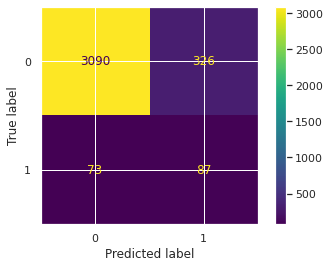

In [122]:
ConfusionMatrixDisplay.from_predictions(y_te, mnb_tfidf_predict)

plt.show()

### ROC Using Probability

In [123]:
mnb_tfidf_proba = mnb.predict_proba(tv_test_reviews)

Text(0.5, 1.0, 'ROC Curves - Multinomial Naive Bayes')

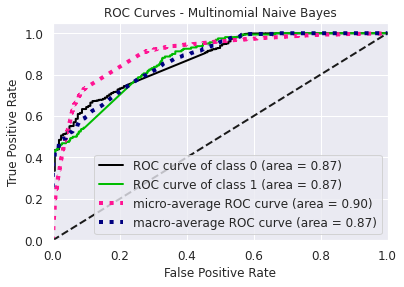

In [124]:
plot = skplt.metrics.plot_roc(y_te, mnb_tfidf_proba)
plt.title("ROC Curves - Multinomial Naive Bayes")

In [125]:
mnb_tfidf_proba = mnb_tfidf_proba[:, 1]

In [126]:
mnb_tfidf_auc = roc_auc_score(y_te, mnb_tfidf_proba)

In [127]:
print('Naive Bayes: ROC AUC=%.2f' % (mnb_tfidf_auc))

Naive Bayes: ROC AUC=0.87


In [128]:
mnb_tfidf_fpr, mnb_tfidf_tpr, _ = roc_curve(y_te, mnb_tfidf_proba)

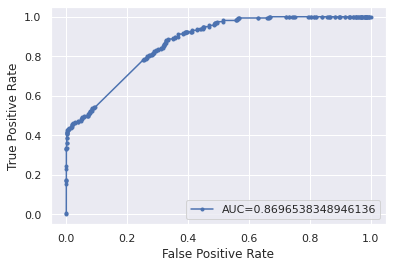

In [129]:
plt.plot(mnb_tfidf_fpr, mnb_tfidf_tpr, marker='.', label="AUC="+str(mnb_tfidf_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()


## SVM

In [130]:
start = time.time()

ss = svm.SVC(kernel='poly', degree=8.7, probability=True)
ss.fit(X_train_bal, y_train_bal)
svm_pred = ss.predict(X_test)
svm_recall  = metrics.recall_score(y_test, svm_pred)
svm_f1_score = metrics.f1_score(y_test, svm_pred) 

end = time.time()
print('SVM took: ', end - start, "seconds")

In [131]:
print ("Recall with SVM:%.2f "% svm_recall)
print("F1_Score with SVM: %.2f "% svm_f1_score)
print ("AUC score with SVM:", np.round(roc_auc_score(y_test, svm_pred),2))
print("Accuracy with SVM:",round(metrics.accuracy_score(y_test, svm_pred),2))

Recall with SVM:0.80 
F1_Score with SVM: 0.42 
AUC score with SVM: 0.85
Accuracy with SVM: 0.9


In [132]:
svm_proba = ss.predict_proba(X_test)
svm_proba = svm_proba[:, 1]
svm_auc = roc_auc_score(y_test, svm_proba)
print('SVM: ROC AUC=%.2f' % (svm_auc))

SVM: ROC AUC=0.92


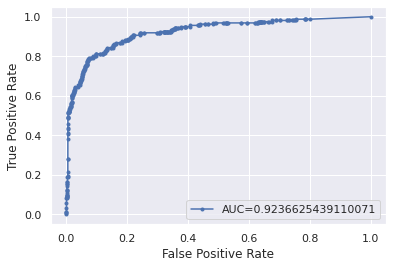

In [133]:
svm_fprs, svm_tprs, _ = roc_curve(y_test, svm_proba)
plt.plot(svm_fprs, svm_tprs, marker='.', label="AUC="+str(svm_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

# KNN

In [134]:
knn = KNeighborsClassifier(n_neighbors = 3)

In [135]:
start = time.time()

KNN = knn.fit(X_train_bal, y_train_bal)
knn_pred = KNN.predict(X_test)

end = time.time()
print('KNN took: ', end - start, "seconds")

KNN took:  2.894272565841675 seconds


In [136]:

knn_recall  = metrics.recall_score(y_test, knn_pred)
knn_f1_score = metrics.f1_score(y_test,knn_pred) 

print ("Recall with kNN:%.2f "% knn_recall)
print("F1_Score with kNN: %.2f "% knn_f1_score)
print("Accuracy with kNN:",round(metrics.accuracy_score(y_test, knn_pred),2))

Recall with kNN:0.78 
F1_Score with kNN: 0.54 
Accuracy with kNN: 0.94


### Confusion Matrix for kNN

In [138]:
#Generate the confusion matrix
knn_cf_matrix = confusion_matrix(y_test, knn_pred)

print(knn_cf_matrix)

[[3239  177]
 [  35  125]]


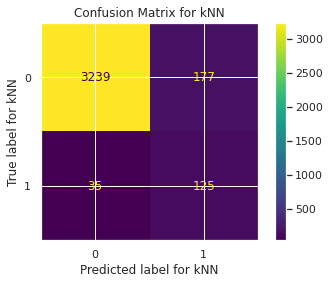

In [139]:
ConfusionMatrixDisplay.from_predictions(y_test, knn_pred)
plt.xlabel('Predicted label for kNN')
plt.ylabel('True label for kNN')
plt.title('Confusion Matrix for kNN')
plt.show()

### ROC Under Probbaility

In [141]:
knn_proba = KNN.predict_proba(X_test)

Text(0.5, 1.0, 'ROC Curves - kNN')

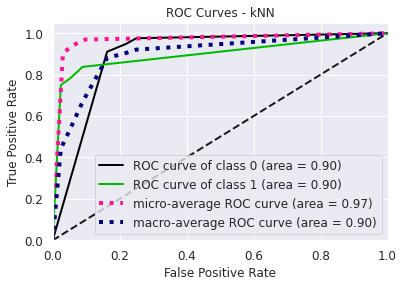

In [142]:
plot = skplt.metrics.plot_roc(y_test, knn_proba)
plt.title("ROC Curves - kNN")

In [143]:
knn_proba = knn_proba[:, 1]

In [144]:
knn_auc = roc_auc_score(y_test, knn_proba)

print('kNN: ROC AUC=%.2f' % (knn_auc))

kNN: ROC AUC=0.90


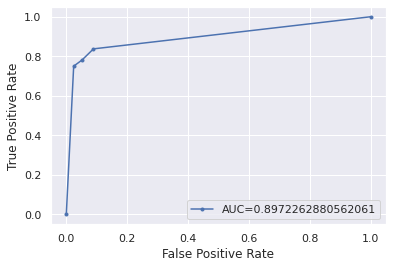

In [145]:
knn_fprs, knn_tprs, _ = roc_curve(y_test, knn_proba)

plt.plot(knn_fprs, knn_tprs, marker='.', label="AUC="+str(knn_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

## EDA


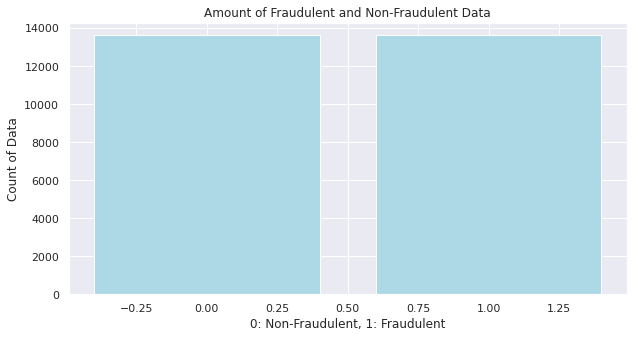

In [146]:
fig = plt.figure(figsize = (10, 5))
lst1 = (0,1)
lst2 = (13598,13598)
#  Bar plot
plt.bar(lst1, lst2, color ='lightblue')
plt.xlabel("0: Non-Fraudulent, 1: Fraudulent")
plt.ylabel("Count of Data")
plt.title("Amount of Fraudulent and Non-Fraudulent Data")
plt.show()

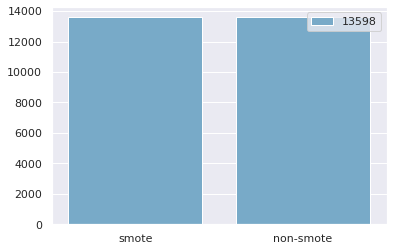

In [147]:
bar_graph_data = {'type': ['smote', 'non-smote'], '0':[13598,13598], '1':[13598,706]}
sns.barplot(x = 'type',
            y = '0',
            hue = '0',
            data = bar_graph_data,
            palette = "Blues")

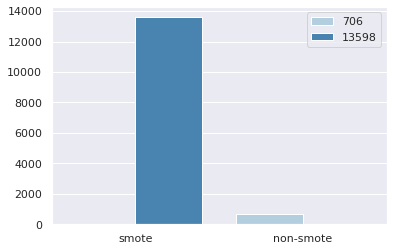

In [148]:
sns.barplot(x = 'type',
            y = '1',
            hue = '1',
            data = bar_graph_data,
            palette = "Blues")

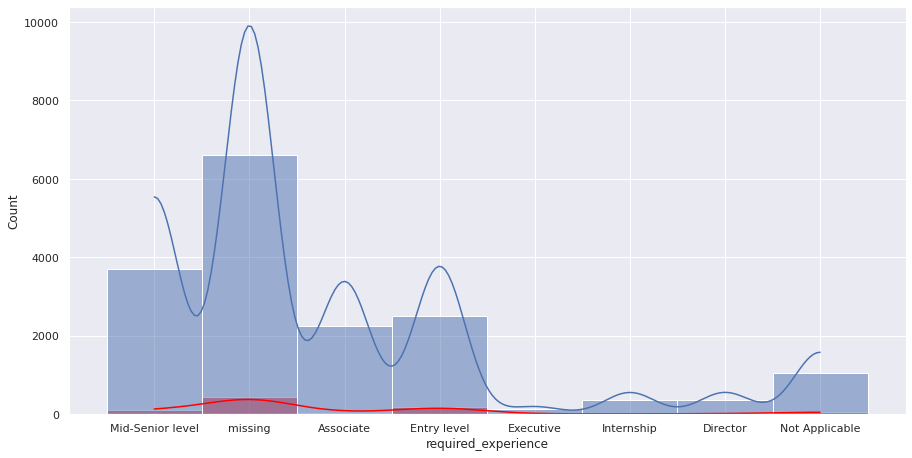

In [149]:
plt.figure(figsize = (15, 7.5))
sns.histplot(x=data[data["fraudulent"]==1]["required_experience"],kde=True,color="red")
sns.histplot(x=data[data["fraudulent"]==0]["required_experience"],kde=True);

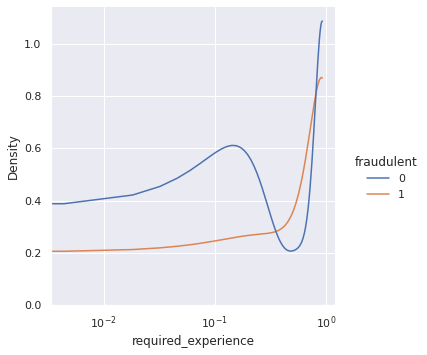

In [150]:
ax=sns.displot(main_data, x='required_experience', hue='fraudulent', kind='kde', common_norm=False, cut=0)
ax.set(xscale="log")

# SGD Classifier

In [151]:
sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000)

In [173]:
start = time.time()

sgd.fit(X_train_bal, y_train_bal)
calibrator = CalibratedClassifierCV(sgd, cv='prefit')
new_sgd = calibrator.fit(X_train_bal, y_train_bal)

sgd_pred = new_sgd.predict(X_test)

end = time.time()
print('SGD took: ', end - start, "seconds")

SGD took:  0.9165480136871338 seconds


In [153]:
clf_recall  = metrics.recall_score(y_test, sgd_pred)
clf_f1_score = metrics.f1_score(y_test,sgd_pred) 


print ("Recall :%.2f "% clf_recall)
print("F1_Score: %.2f "% clf_f1_score)
print ("AUC score :", np.round(roc_auc_score(y_test, sgd_pred),2))
print("Accuracy:",round(metrics.accuracy_score(y_test, sgd_pred),2))

Recall :0.80 
F1_Score: 0.34 
AUC score : 0.83
Accuracy: 0.86


In [154]:
#Generate the confusion matrix
clf_cf_matrix = confusion_matrix(y_test, sgd_pred)

print(clf_cf_matrix)

[[2954  462]
 [  32  128]]


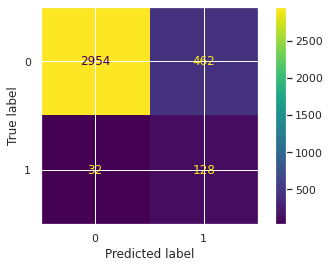

In [155]:
ConfusionMatrixDisplay.from_predictions(y_test, sgd_pred)

plt.show()

In [156]:
sgd_proba = model.predict_proba(X_test)
sgd_proba = sgd_proba[:, 1]
sgd_auc = roc_auc_score(y_test, sgd_proba)
print('SGD: ROC AUC=%.2f' % (sgd_auc))

SGD: ROC AUC=0.91


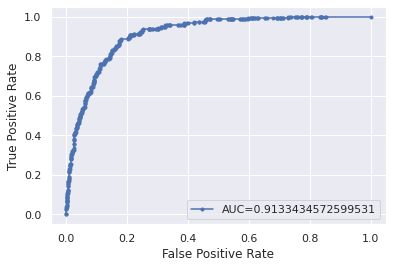

In [157]:
sgd_fprs,sgd_tprs, _ = roc_curve(y_test, sgd_proba)
plt.plot(sgd_fprs, sgd_tprs, marker='.', label="AUC="+str(sgd_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

## SGD with Log Loss

In [158]:
clf = SGDClassifier(loss="log", penalty="l2", max_iter=1000)

In [159]:
%%time
clf.fit(new_X, new_y)
y_pred = clf.predict(X_test)

CPU times: user 578 ms, sys: 11.9 ms, total: 590 ms
Wall time: 594 ms


In [160]:
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),2))

Accuracy: 0.83


### With L1 penalty

In [161]:
clf = SGDClassifier(loss="hinge", penalty="l1", max_iter=1000)

In [162]:
%%time
clf.fit(new_X, new_y)
y_pred = clf.predict(X_test)

CPU times: user 1.36 s, sys: 66.1 ms, total: 1.42 s
Wall time: 1.36 s


In [163]:
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),2))

Accuracy: 0.85


### Ensemble Max Voting

In [175]:
best = VotingClassifier(estimators=[('sgd', sgd), ('rf', rfc), ('nb', model), ('svm', ss), ('knn', knn)], voting='hard')
best.fit(X_train_bal, y_train_bal)
best.score(X_test,y_test)

CPU times: user 4min 57s, sys: 2.43 s, total: 4min 59s
Wall time: 4min 56s


# Result ROC Curve

<Figure size 432x288 with 0 Axes>

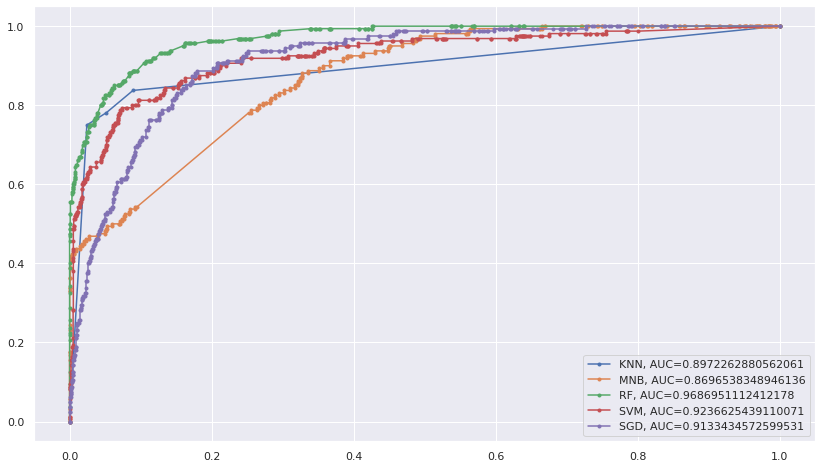

In [166]:
#set up plotting area
plt.figure(0).clf()


figure(figsize=(14, 8))

plt.plot(knn_fprs, knn_tprs, marker='.', label="KNN, AUC="+str(knn_auc))
plt.plot(mnb_tfidf_fpr, mnb_tfidf_tpr, marker='.', label="MNB, AUC="+str(mnb_tfidf_auc))
plt.plot(rf_fpr, rf_tpr, marker='.', label="RF, AUC="+str(rf_auc))
plt.plot(svm_fprs, svm_tprs, marker='.', label="SVM, AUC="+str(svm_auc))
plt.plot(sgd_fprs, sgd_tprs, marker='.', label="SGD, AUC="+str(sgd_auc))

plt.legend()

### EDA

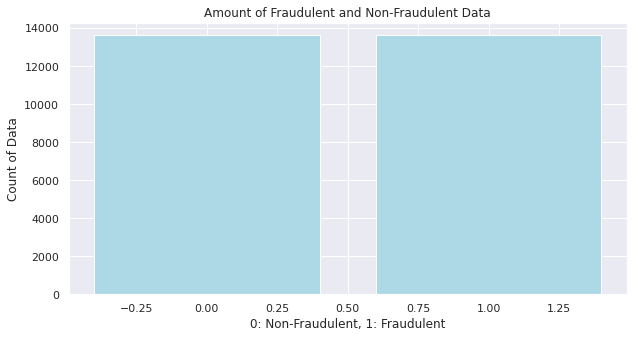

In [167]:
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10, 5))
lst1 = (0,1)
lst2 = (13598,13598)
#  Bar plot
plt.bar(lst1, lst2, color ='lightblue')
plt.xlabel("0: Non-Fraudulent, 1: Fraudulent")
plt.ylabel("Count of Data")
plt.title("Amount of Fraudulent and Non-Fraudulent Data")
plt.show()

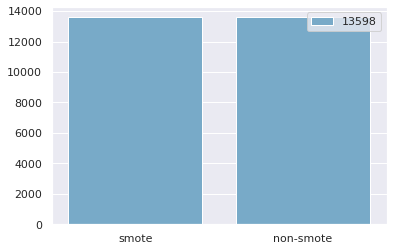

In [168]:
bar_graph_data = {'type': ['smote', 'non-smote'], '0':[13598,13598], '1':[13598,706]}
sns.barplot(x = 'type',
            y = '0',
            hue = '0',
            data = bar_graph_data,
            palette = "Blues")

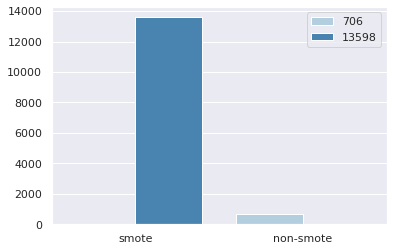

In [169]:
sns.barplot(x = 'type',
            y = '1',
            hue = '1',
            data = bar_graph_data,
            palette = "Blues")

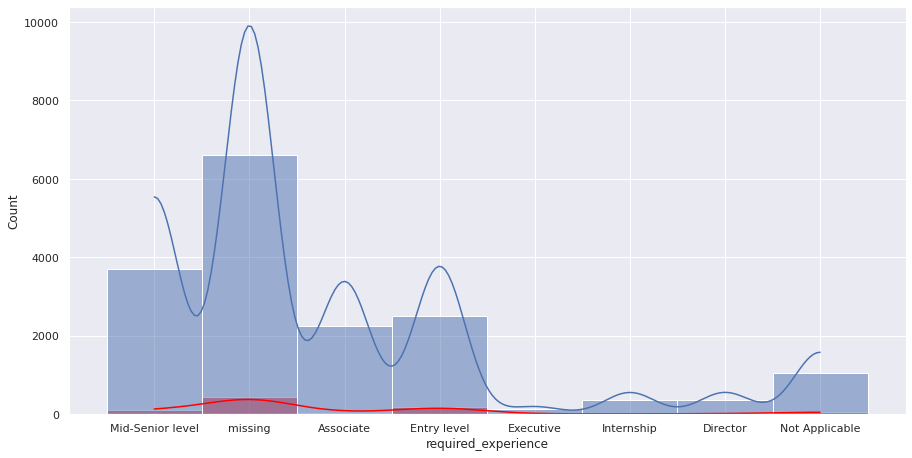

In [170]:
plt.figure(figsize = (15, 7.5))
sns.histplot(x=data[data["fraudulent"]==1]["required_experience"],kde=True,color="red")
sns.histplot(x=data[data["fraudulent"]==0]["required_experience"],kde=True);

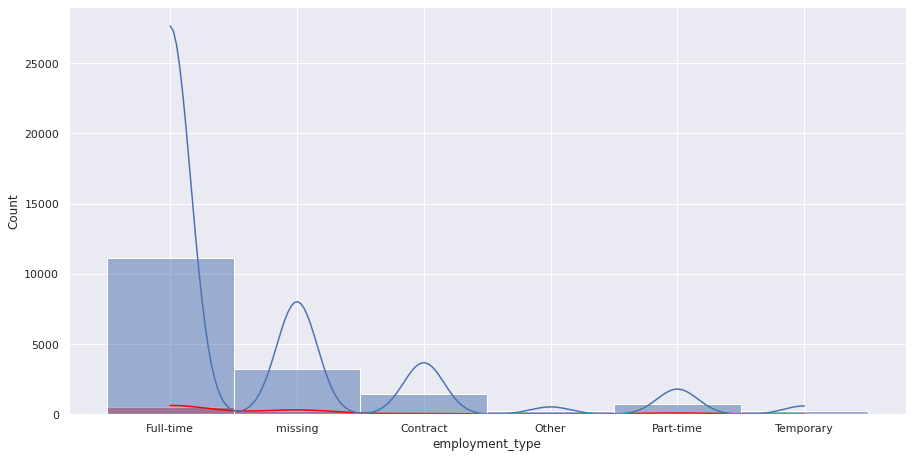

In [171]:
plt.figure(figsize = (15, 7.5))
sns.histplot(x=data[data["fraudulent"]==1]["employment_type"],kde=True,color="red")
sns.histplot(x=data[data["fraudulent"]==0]["employment_type"],kde=True);

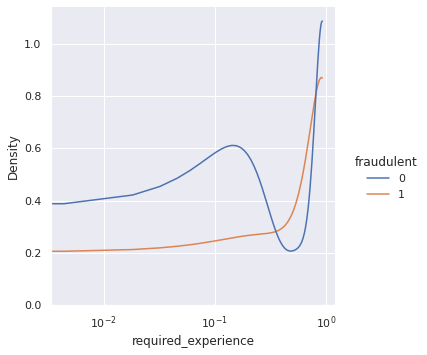

In [172]:
ax=sns.displot(main_data, x='required_experience', hue='fraudulent', kind='kde', common_norm=False, cut=0)
ax.set(xscale="log")